# Задача предсказания оттока клиентов для сети магазинов крупного ритейлера

В этой задаче нам необходимо: 
1. проанализировать данные и определить оптимальную методологию определения отточных клиентов
2. разработать модель вероятности оттока клиентов по выбранной вами методологии
3. дать интерпретацию разработанной модели, ответить на вопрос: какие признаки наиболее влияют на отток клиентов.


## Выбранная методология:
Существует множество разных подходов к задаче предсказания оттока клиентов. Можно подходить как к задаче классификации с определенным горизонтом прогнозирования (например, 1 мес), так и как к задаче регрессии - сколько месяцев/недель/дней осталось до предполагаемого оттока клиента. 

В сфере ритейла очень сложно определить, какого клиента считать ушедшим, поскольку покупатели имеют разное поведение: 
* для кого-то привычно заходить в магазин каждый день и совершать небольшую покупку;
* некоторые люди привыкли закупаться на 1-2 недели вперед и делать это в выходные дни;
* есть также группа людей, которые покупают продукты/товары для своего бизнеса (например, кофейни) или для перепродажи - тогда они могут возвращаться за покупкой раз в 1-2 месяца и покупать оптом;
* еще есть клиенты, которые совершили 1-2 покупки и больше не возвращались (по-крайней мере с той же самой картой лояльности, по которой мы можем отслеживать историю клиента.

1. В текущем проекте было принято решение посмотреть с какой частотой в среднем клиенты совершают покупку (т.е. сколько дней проходит между покупками) и на основании этих цифр выбрать оптимальное время неактивности, после которого считать клиента ушедшим.

2. Таким образом мы разметили всю выборку на ушедших и активных покупателей (доля ушедших получилась 9.3%).

3. На основе транзакционных данных сгенерировали новые фичи:
    1. Часть фичей характеризует портрет пользователя в целом, за весь период наблюдений: пол, возраст, город, доля промо-товаров в чеке, доля товаров бренда "Лента" в чеке, сумма трат за период, количество покупок за период, средняя сумма покупки, количество покупок в неделю, среднее количество товаров в чеке;
    2. Вторая часть фичей отражают динамику пользователя по неделям:
        * это 3 группы признаков, агрегированных по неделям (сумма покупки, количество покупок, количество купленных товаров);
        * получилось 30 признаков, каждый из которых является скользящим средним, рассчитанным для окна 6 недель.

4. Все признаки были разделены на обучающую и тестовую (20%) выборки. К обучающей выборке была применена техника SMOTE для устранения дисбаланса классов.
4. На обучающем выборке были построены 2 модели: логистическая регрессия и LightGBM классификатор. Лучший результат показал бустинг.

In [ ]:
!pip install pyspark
!pip install optuna
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 25 kB/s 
     |████████████████████████████████| 199 kB 40.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1d5153b7daab47f9b41784d1905bc8d01e90d258a9d5b772db385fa3eca2ee24
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 58.7 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 147 kB 52.5 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 50.4

## Импорт библиотек

In [ ]:
# python standard library
from collections import Counter
from datetime import timedelta, datetime
import requests

# data analysis
import numpy as np
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType

# visualization
from lightgbm import plot_importance
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# machine learning
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import optuna
from sklearn.metrics import (
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LogisticRegression

# misc
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 22})
sns.set_theme(style="darkgrid")

RS=42

# Исследовательский анализ данных

Исследовательский анализ будем проводить с помощью инструментов Spark и Pandas, а также при помощи визуализации (Seaborn, Plotly).

Задачи:
* Познакомиться с данными и с их распределением;
* Определить, какого покупателя считать ушедшим (churn).

Загрузка датасетов с Яндекс.Диска

In [ ]:
# transactions
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/1KjdaIV0BGYPSg
# clients
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/T3fgpOoBjdWhrw
# materials
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Dbl7lxARhCtUhQ
# plants
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/H8TbMXtCm7xvHQ

--2022-08-18 13:25:15--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/1KjdaIV0BGYPSg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/aea211e2e0324794211fd3c63b5ea51bd81e4cefae94f633190a04751ac98869/62fe5b64/oziA8xK5NqwEihD_OfT5JD_cNEiuoDFyX6lNoh9Skyf48S3ZMTsikslf7j6hO2Gdxr4FPShxexiYixkyNNclpw%3D%3D?uid=0&filename=transactions.parquet&disposition=attachment&hash=U4frjdNiXjxe4OoBrHUe4h3sns1njU0nDtm7%2BwXr4wLNOhdrN6eJ7sMoI3yA2hzbq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Foctet-stream&owner_uid=104506037&fsize=1273100568&hid=ae5e5c272d71fb012fa7c67ef7507952&media_type=data&tknv=v2 [following]
--2022-08-18 13:25:16--  https://downloader.disk.yandex.ru/disk/aea211e2e0324794211fd3c63b5ea51bd81e4cefae94f633190a04751ac98869/62fe5b64/oziA8xK5NqwEihD

In [ ]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('App')\
        .config("spark.driver.memory", "12g")\
        .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
tr = spark.read.parquet('1KjdaIV0BGYPSg')
tr.printSchema()

root
 |-- chq_id: string (nullable = true)
 |-- plant: string (nullable = true)
 |-- chq_date: timestamp (nullable = true)
 |-- chq_position: string (nullable = true)
 |-- client_id: string (nullable = true)
 |-- material: string (nullable = true)
 |-- sales_count: double (nullable = true)
 |-- sales_sum: double (nullable = true)
 |-- is_promo: long (nullable = true)



In [ ]:
clients = spark.read.csv(
    'T3fgpOoBjdWhrw',
    inferSchema=True, header=True)
clients.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- birthyear: double (nullable = true)



In [ ]:
plants = spark.read.csv(
    'H8TbMXtCm7xvHQ',
    inferSchema=True, header=True)
plants.printSchema()

root
 |-- plant: string (nullable = true)
 |-- plant_type: string (nullable = true)
 |-- city: string (nullable = true)



In [ ]:
materials = spark.read.csv(
    'Dbl7lxARhCtUhQ',
    inferSchema=True, header=True)
materials.printSchema()

root
 |-- material: string (nullable = true)
 |-- hier_level_1: string (nullable = true)
 |-- hier_level_2: string (nullable = true)
 |-- hier_level_3: string (nullable = true)
 |-- hier_level_4: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- is_private_label: integer (nullable = true)
 |-- is_alco: integer (nullable = true)



### Логи транзакций

In [ ]:
tr.count()

32109414

In [ ]:
tr.show(10)

+--------------------+--------------------+-------------------+------------+--------------------+--------------------+-----------+---------+--------+
|              chq_id|               plant|           chq_date|chq_position|           client_id|            material|sales_count|sales_sum|is_promo|
+--------------------+--------------------+-------------------+------------+--------------------+--------------------+-----------+---------+--------+
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01 00:00:00|         004|90fca68123e692a00...|232cfe8b28970434f...|        2.0|   146.98|       0|
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01 00:00:00|         003|90fca68123e692a00...|12ec64451b8e426db...|        1.0|   249.99|       1|
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01 00:00:00|         012|90fca68123e692a00...|1212ff8ecf53aebef...|        1.0|    47.99|       1|
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01 00:00:00|         013|90fca68123e692a00...|121

Преобразуем признаки:
* `chq_position`, отвечающий за порядковый номер товара в чеке, в целочисленный тип данных.

* `chq_date` из типа `timestamp` преобразуем в дату, так как время покупки у нас всё равно отсутствует.

In [ ]:
tr = tr.withColumn('chq_position', F.col('chq_position').cast("int"))
tr = tr.withColumn('chq_date', F.col('chq_date').cast('date'))

In [ ]:
tr.show(1)

+--------------------+--------------------+----------+------------+--------------------+--------------------+-----------+---------+--------+
|              chq_id|               plant|  chq_date|chq_position|           client_id|            material|sales_count|sales_sum|is_promo|
+--------------------+--------------------+----------+------------+--------------------+--------------------+-----------+---------+--------+
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01|           4|90fca68123e692a00...|232cfe8b28970434f...|        2.0|   146.98|       0|
+--------------------+--------------------+----------+------------+--------------------+--------------------+-----------+---------+--------+
only showing top 1 row



In [ ]:
tr.describe(['chq_position', 'sales_count', 'sales_sum', 'is_promo']).show()

+-------+------------------+------------------+------------------+-------------------+
|summary|      chq_position|       sales_count|         sales_sum|           is_promo|
+-------+------------------+------------------+------------------+-------------------+
|  count|          32109414|          32109414|          32109414|           32109414|
|   mean|11.212958916036275|1.3192295561980023|122.88696971533868|0.48338381385596135|
| stddev| 11.20523542388457|2.0153870890755163|250.20021159116604|  0.499723833867537|
|    min|                 1|           -1656.0|          -98388.0|                  0|
|    max|               244|            3000.0|          198571.5|                  1|
+-------+------------------+------------------+------------------+-------------------+



In [ ]:
tr.orderBy('sales_sum').show(10)

+--------------------+--------------------+----------+------------+--------------------+--------------------+-----------+---------+--------+
|              chq_id|               plant|  chq_date|chq_position|           client_id|            material|sales_count|sales_sum|is_promo|
+--------------------+--------------------+----------+------------+--------------------+--------------------+-----------+---------+--------+
|61b17e3843e880f6b...|c81c2b9e997a81f84...|2016-10-21|           1|596f837a638189cb1...|df61ac05dd83388e5...|      -60.0| -98388.0|       0|
|af66285b6d2d3a7e6...|c81c2b9e997a81f84...|2017-01-12|           2|596f837a638189cb1...|ec13cc81075855dfe...|    -1656.0|-82783.44|       0|
|1a78ad8709fa810a2...|c81c2b9e997a81f84...|2016-10-21|           2|596f837a638189cb1...|674bb539ff1b5d62c...|      -45.0| -58491.0|       0|
|cc50070834892c534...|c81c2b9e997a81f84...|2016-10-21|           1|596f837a638189cb1...|ec13cc81075855dfe...|      -68.0|-57625.24|       0|
|af2b422068ed

Отрицательные суммы в количестве товаров и сумме покупки вероятно свидетельствуют о возврате товаров покупателем.

In [ ]:
print('Количество уникальных покупателей:', tr.select('client_id').distinct().count())

Количество уникальных покупателей: 100000


In [ ]:
print('Количество уникальных транзакций:', tr.select('chq_id').distinct().count())

Количество уникальных транзакций: 2964775


In [ ]:
print('Количество уникальных магазинов:', tr.select('plant').distinct().count())

Количество уникальных магазинов: 388


Создадим временные таблицы, к которым будем обращаться с помощью SQL-запросов.
Это поможет нам при исследовании данных, так и при создании новых признаков.


In [ ]:
tr.createOrReplaceTempView('tr')
plants.createOrReplaceTempView('pl')

In [ ]:
uniq_chq_by_date = spark.sql('''
SELECT chq_date, pl.city, 
       COUNT(DISTINCT chq_id) chq_cnt,
       DAYOFWEEK(chq_date) as dow
FROM tr
JOIN pl
on tr.plant = pl.plant
GROUP BY chq_date, pl.city
ORDER BY chq_date
''')

In [ ]:
px.line(uniq_chq_by_date.toPandas(), 
        x='chq_date', y='chq_cnt', color='city', 
        title='Количество уникальных транзакций в день')

**Вывод по графику:**

В графике количества транзакций за год наблюдается ожидаемая недельная сезонность - в конце недели количество покупок больше, люди наперед закупаются необходимыми товарами в свободное время.

Окончательно неясно, чем был вызван пик увеличения транзакций 1-5 апреля 2017 года и 10-12 июня 2017 года. Есть несколько предположений:
* Основное предположение: увеличение покупок связано c проводимыми промо-акциями;
* Усиление пика 3-4 апреля еще может быть связано с террактом, произошедшим 3 апреля 2017 года в метрополитене СПб (на фоне паники увеличились покупки продуктов и других товаров);
* 12 июня согласно большинству региональных законов запрещена продажа алкоголя (День России), поэтому многие покупатели пришли за напитками накануне.

### Справочник клиентов

In [ ]:
clients.summary().show()

+-------+--------------------+------+--------------+------------------+
|summary|           client_id|gender|          city|         birthyear|
+-------+--------------------+------+--------------+------------------+
|  count|               99995| 99640|         99995|             98219|
|   mean|                null|  null|          null| 1975.125963408302|
| stddev|                null|  null|          null|14.964636744529614|
|    min|0000d48a8891cd462...|     F|        Moscow|            1900.0|
|    25%|                null|  null|          null|            1964.0|
|    50%|                null|  null|          null|            1977.0|
|    75%|                null|  null|          null|            1987.0|
|    max|fffd3e78e3ea6bf00...|     M|St. Petersburg|            2049.0|
+-------+--------------------+------+--------------+------------------+



In [ ]:
clients.show(5)

+--------------------+------+------+---------+
|           client_id|gender|  city|birthyear|
+--------------------+------+------+---------+
|1a47d62dddacc03fe...|     M| Other|   1990.0|
|9cb909f701d25d548...|     F| Other|   1969.0|
|d5da0f5b841b4f833...|     M| Other|   1976.0|
|13ed7f16810b17b8c...|     F|Moscow|   1966.0|
|215fe3ea7d5bf0415...|     F| Other|   1988.0|
+--------------------+------+------+---------+
only showing top 5 rows



In [ ]:
clients = clients.withColumn('age', (2017 - F.col('birthyear')).cast('integer'))
clients = clients.drop('birthyear')

In [ ]:
clients.show(2)

+--------------------+------+-----+---+
|           client_id|gender| city|age|
+--------------------+------+-----+---+
|1a47d62dddacc03fe...|     M|Other| 27|
|9cb909f701d25d548...|     F|Other| 48|
+--------------------+------+-----+---+
only showing top 2 rows



Удалим всех клиентов с ненастоящим возрастом (таковым будем считать возраст мeнее 18 и более 100 лет)

*Может это и не плохие клиенты, но карта лояльности выдается с 18 лет, а долгожители более 100 лет это редкие исключения.*

In [ ]:
clients = clients.filter('age between 18 and 100')

In [ ]:
clients.count()

96280

Переименуем колонку 'city' в 'city_client', чтобы после объединения не было путаницы с городом магазина.

In [ ]:
clients = clients.withColumnRenamed("city", "city_client")

In [ ]:
clients.show(1)

+--------------------+------+-----------+---+
|           client_id|gender|city_client|age|
+--------------------+------+-----------+---+
|1a47d62dddacc03fe...|     M|      Other| 27|
+--------------------+------+-----------+---+
only showing top 1 row



In [ ]:
clients_pd = clients.toPandas()

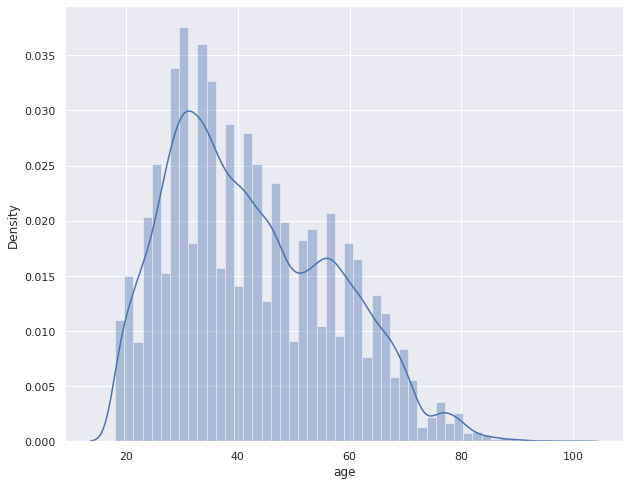

In [ ]:
sns.distplot(clients_pd['age']);

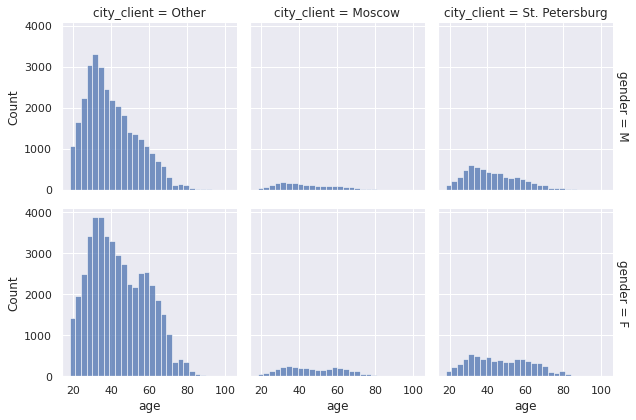

In [ ]:
sns.displot(
    clients_pd, x='age', col='city_client', row='gender',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True));

### Справочник магазинов


In [ ]:
plants.printSchema()

root
 |-- plant: string (nullable = true)
 |-- plant_type: string (nullable = true)
 |-- city: string (nullable = true)



In [ ]:
plants.summary().show()

+-------+--------------------+----------+--------------+
|summary|               plant|plant_type|          city|
+-------+--------------------+----------+--------------+
|  count|                 388|       388|           388|
|   mean|                null|      null|          null|
| stddev|                null|      null|          null|
|    min|00fdea78e677259a3...|        HM|        Moscow|
|    25%|                null|      null|          null|
|    50%|                null|      null|          null|
|    75%|                null|      null|          null|
|    max|ffe49cdf45d56b04b...|        SM|St. Petersburg|
+-------+--------------------+----------+--------------+



In [ ]:
plants.show(5)

+--------------------+----------+--------------+
|               plant|plant_type|          city|
+--------------------+----------+--------------+
|95b09698fda1f64af...|        HM|St. Petersburg|
|926abae84a4bd33c8...|        HM|St. Petersburg|
|ae2bac2e4b4da805d...|        HM|St. Petersburg|
|0e7e3cf0ded4d9db8...|        HM|St. Petersburg|
|540bd55a2cf295b8e...|        HM|St. Petersburg|
+--------------------+----------+--------------+
only showing top 5 rows



In [ ]:
plants = plants.withColumnRenamed("city","city_plant")

In [ ]:
plants_pd = plants.toPandas()

In [ ]:
px.histogram(plants_pd, x='city_plant', color='plant_type')

**Вывод по графику:** 

* Среди всех магазинов сети преобладают гипермаркеты;
* В городах кроме СПб и Москвы гипермаркетов в 2 раза больше, чем супермаркетов (более новый формат магазинов для сети);
* В СПб гипермаркетов немного больше, чем супермаркетов (27 против 19);
* В Москве ситуация обратная - супермаркетов немного больше, чем гипермаркетов (15 против 11).

### Справочник товаров

In [ ]:
materials.summary().show()

+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|summary|            material|hier_level_1|        hier_level_2|        hier_level_3|        hier_level_4|              vendor|   is_private_label|             is_alco|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|  count|              105609|      105609|              105609|              105609|              105609|              105609|             105609|              105609|
|   mean|                null|        null|                null|                null|                null|                null|0.15631243549318713|0.048660625514870895|
| stddev|                null|        null|                null|                null|                null|                null|0.36315300736961353| 0.21515

In [ ]:
materials.show(5)

+--------------------+------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+
|            material|hier_level_1|        hier_level_2|        hier_level_3|        hier_level_4|              vendor|is_private_label|is_alco|
+--------------------+------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+
|35cbdf61de9e19c8b...|     NONFOOD|ea5d2f1c4608232e0...|99cad265a1768cc2d...|9eed45f71360b4b1e...|212a38db0ddcd009f...|               0|      0|
|c0b0bf24d4ec71da3...|     NONFOOD|ea5d2f1c4608232e0...|99cad265a1768cc2d...|de2eb747e0896c050...|9b0b6c7d55413ad3b...|               0|      0|
|f0fc5e654a81a7c4b...|     NONFOOD|ea5d2f1c4608232e0...|99cad265a1768cc2d...|8a969031832c535da...|9b0b6c7d55413ad3b...|               0|      0|
|353693e64fb5f9e2d...|     NONFOOD|ea5d2f1c4608232e0...|b58f7d184743106a8...|4c0dc012ebb679a18...|a3c8be149d718771e...|           

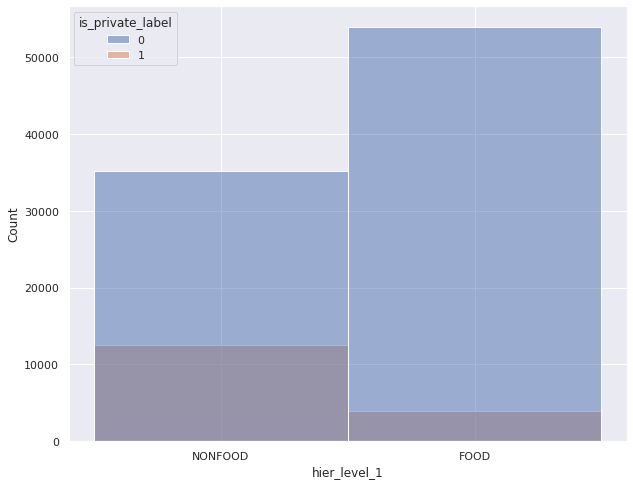

In [ ]:
materials_pd = materials.select(['hier_level_1', 'is_private_label']).toPandas()
sns.histplot(data=materials_pd, x='hier_level_1', hue='is_private_label')
del materials_pd;

**Вывод по графику:**

* В ассортименте магазинов в целом немного больше продовольственных товаров, чем непродовольственных;
* Однако товаров собственного бренда "Лента" примерно в 3,5 раза больше в категории непродовольственных.

### Какого покупателя считать ушедшим?
Это очень сложный вопрос, особенно в сфере ритейла и e-commerce.

Чтобы не уходить в эвристики и не брать цифры с потолка, посчитаем, сколько в среднем у покупателя проходит дней между покупками.

Следующий SQL-запрос обращается к таблице с транзакциями, группирует её по покупателям и для каждого считает среднее количество дней между транзакциями.

* Формула: `(дата последней покупки - дата первой покупки) / (количество уникальных чеков клиента - 1)`. 
* Здесь SQL возвращает нам результат в виде типа `interval day to second`, который мы переводим в тип `int` и получаем значение интервала в секундах. Остаётся только поделить на 86400, чтобы перейти к дням.
* Округляем до 4-х цифр после запяттой.

In [ ]:
days_bw = spark.sql('''
SELECT client_id, MAX(chq_date) as last_date,
        ROUND(
            CAST(
                (MAX(chq_date) - MIN(chq_date)) / (COUNT(DISTINCT chq_id) - 1) AS int
                 ) / 86400, 4
              ) as d_bw
FROM tr
GROUP BY client_id
HAVING COUNT(DISTINCT chq_id) > 1
''')

In [ ]:
days_bw.select(F.avg('d_bw')).show()

+-----------------+
|        avg(d_bw)|
+-----------------+
|20.50722158400027|
+-----------------+



In [ ]:
days_bw.select('d_bw').describe().show()

+-------+------------------+
|summary|              d_bw|
+-------+------------------+
|  count|            100000|
|   mean| 20.50722158400027|
| stddev|19.786992683086826|
|    min|               0.0|
|    max|             182.0|
+-------+------------------+



In [ ]:
days_bw.filter('d_bw <= 42').count() / days_bw.count()

0.89216


> * **Среднее количество времени между покупками 20,5 дней**;
* **89% покупателей возвращаются за покупкой в течение 6 недель.**



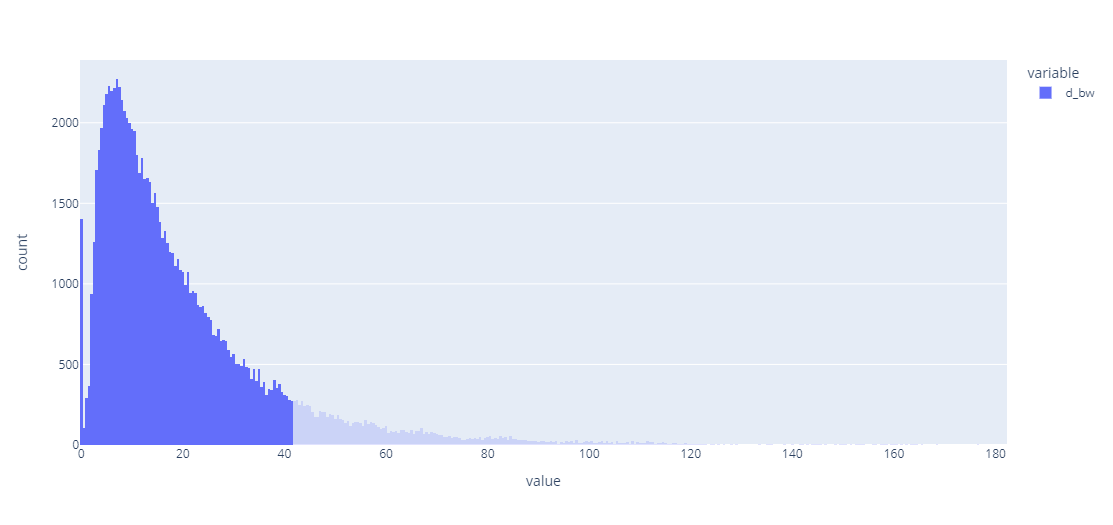

In [ ]:
px.histogram(days_bw.toPandas()['d_bw'])

**Вывод:**

* Среднее количество дней между покупками для всех наших 100 тыс клиентов - 20,5 дней;
* 89% покупателей возвращаются за покупкой в течение 6 недель;
* Около 1500 тысяч клиентов совершают покупки чаще 1 раза в день;
* Есть покупатели, которые возвращаются и спустя полгода (максимум 182 дня);
* Будем считать ушедшим покупателя, который не совершал новых покупок уже 6 недель.

# Feature Engineering
Далее будем собирать сгруппированный по клиентам датафрейм.


---
Далее сокращенные названия столбцов:
* cpw - cheque per week, количество покупок в неделю.
* ms - mean sum, средняя сумма покупки за период
* ipc - items per cheque, среднее количество позиций в чеке за период

> Портрет покупателя, признаки за весь период (9 мес):
1. client_id
2. gender - пол покупателя
3. city_client - город покупателя
4. age - возраст покупателя
5. promo_ratio - средняя доля товаров в чеке, купленных по промо-цене 
6. chq_cnt_9m - количество покупок за период
4. total_sum_9m - сумма покупок за период
5. **cpw_9m** - среднее количество покупок в неделю за период
6. **ms_9m** - средняя сумма покупки за период
7. **ipc_9m** - среднее количество позиций в чеке за период


In [ ]:
spark.sql('''
SELECT client_id, MIN(chq_date) mind
FROM tr
GROUP BY client_id
ORDER BY mind DESC
''').show(5)

+--------------------+----------+
|           client_id|      mind|
+--------------------+----------+
|410aa2594dc0f21fc...|2017-01-03|
|953bc7d40d237e09a...|2017-01-03|
|a0f9d53b10b03c624...|2017-01-03|
|28498001396c568a2...|2017-01-03|
|1a948301bfc0bf3a3...|2017-01-03|
+--------------------+----------+
only showing top 5 rows



Наши самые "молодые" клиенты пришли не позднее 3 января 2017 года.
Значит максимальный период наблюдений, который мы можем себе позволить - ровно 9 месяцев (3 янв 2017 - 4 окт 2017).

* Для обучения модели возьмем период 36 недель.
---

> План действий:

1. Отфильтруем датасет с транзакциями по этому периоду.
2. Выполним разметку: ушедшими считаем покупателей, не совершавших покупки в течение 42 дней до 1 авг 2017.
3. Создадим новые признаки, характеризующие активность пользователей.

In [ ]:
df_last_date = tr.select(F.max('chq_date')).toPandas().iloc[0, 0]
delta_36weeks = (df_last_date - timedelta(weeks=36)).strftime("%Y-%m-%d")

tr_filtered = tr.filter('chq_date >= "{}"'.format(delta_36weeks))

tr_filtered.count()

21803634

In [ ]:
tr_filtered.createOrReplaceTempView('trf')
materials.createOrReplaceTempView('materials')

In [ ]:
del tr

In [ ]:
df = tr_filtered.select('client_id').distinct()
df.printSchema()

root
 |-- client_id: string (nullable = true)



In [ ]:
df = df.join(clients, on='client_id')

In [ ]:
from_materials = spark.sql('''
SELECT client_id, 
       AVG(is_private_label) as ratio_private_label,
       AVG(is_alco) as ratio_alco
FROM trf
JOIN materials
ON trf.material = materials.material
GROUP BY client_id
''')

In [ ]:
df = df.join(from_materials, on='client_id')

In [ ]:
df.count()

89213

In [ ]:
df.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- city_client: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ratio_private_label: double (nullable = true)
 |-- ratio_alco: double (nullable = true)



In [ ]:
period_7m = spark.sql('''
SELECT client_id,
       AVG(is_promo) as promo_ratio,
       COUNT(DISTINCT chq_id) as chq_cnt_9m,
       SUM(sales_sum) as total_sum_9m,
       (COUNT(DISTINCT chq_id) 
        / (DATEDIFF(day, MIN(chq_date), MAX(chq_date)) + 1)) * 7 as cpw_9m,
       SUM(sales_sum) / COUNT(DISTINCT chq_id) as ms_9m,
       COUNT(chq_position) / COUNT(DISTINCT chq_id) as ipc_9m
FROM trf
GROUP BY client_id
''')

In [ ]:
df = df.join(period_7m, on='client_id')
del period_7m

In [ ]:
df.show(10)

+--------------------+------+--------------+---+-------------------+--------------------+-------------------+----------+-----------------+------------------+------------------+------------------+
|           client_id|gender|   city_client|age|ratio_private_label|          ratio_alco|        promo_ratio|chq_cnt_9m|     total_sum_9m|            cpw_9m|             ms_9m|            ipc_9m|
+--------------------+------+--------------+---+-------------------+--------------------+-------------------+----------+-----------------+------------------+------------------+------------------+
|0000d48a8891cd462...|     M|St. Petersburg| 59|0.18893129770992367|0.001908396946564...|0.41714285714285715|        32|          68941.0| 1.032258064516129|        2154.40625|          16.40625|
|00076dd9aa78642b7...|     F|         Other| 51|                0.8|                 0.0|                1.0|         1|887.9999999999999|               7.0| 887.9999999999999|               5.0|
|0008322584b6781d6..

In [ ]:
df.count()

89213

#### Скользящее среднее по агрегациям за неделю
Чтобы рассчитывать скользящее среднее с каким либо окном нам нужно сперва посчитать признаки за каждую неделю. Мы работаем с максимально доступным диапазоном в 36 недель(с 3 янв 2017 по 3 окт 2017)
* Сумма трат за неделю 
* Количество покупок за неделю
* Количество купленных товаров за неделю

In [ ]:
def create_weekly_features(week_number: int):
    
    date_format = "%Y-%m-%d"
    start_date = df_last_date - timedelta(weeks=(37 - week_number))
    end_date = start_date + timedelta(days=6)

    query = '''
    SELECT client_id,
        SUM(sales_sum) AS sum_{week_number}w,
        COUNT(DISTINCT chq_id) AS chqs_{week_number}w,
        COUNT(DISTINCT chq_position) AS items_{week_number}w
    FROM trf
    WHERE chq_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY client_id
    '''.format(week_number=week_number,
                start_date=start_date.strftime(date_format),
                end_date=end_date.strftime(date_format))
    
    return spark.sql(query)

In [ ]:
weeks_sum = []
for i in range(1,37):
    weeks_sum.append(create_weekly_features(i))

In [ ]:
cols_for_MA = weeks_sum[0]
for df_no in range(1, len(weeks_sum)):
    cols_for_MA = cols_for_MA.join(weeks_sum[df_no], on='client_id', how='full')

In [ ]:
cols_for_MA.count()

92543

In [ ]:
cols_for_MA = cols_for_MA.fillna(0).toPandas()

In [ ]:
cols_for_MA = cols_for_MA.set_index('client_id')

In [ ]:
def moving_average(df, window_size: int, features: list, col_name: str=None):

    windows = df[features].T.rolling(window_size).mean()
    results = windows.T.iloc[:, window_size:] 
    
    new_cols_names = []
    for i in range(window_size + 1, 37):
        new_cols_names.append('MA_{col_name}_{i}'.format(ws=window_size, 
                                                              col_name=col_name,
                                                              i=i))
    results.columns = new_cols_names
    return results

In [ ]:
def get_list_of_cols(df, col_name: str=None):
    col_names = [col for col in df.columns if col.rfind(col_name) != -1]
    return col_names

In [ ]:
sum_cols = get_list_of_cols(cols_for_MA, 'sum_')
chqs_cols = get_list_of_cols(cols_for_MA, 'chqs_')
items_cols = get_list_of_cols(cols_for_MA, 'items_')

In [ ]:
cols_after_MA = moving_average(cols_for_MA, 6, sum_cols, 'sum')
cols_after_MA = cols_after_MA.join(moving_average(cols_for_MA, 6, chqs_cols, 'chqs'))
cols_after_MA = cols_after_MA.join(moving_average(cols_for_MA, 6, items_cols, 'items'))

Функция `lineplot_new_features` визуализирует новые признаки, рассчитанные выше.

Функция принимает на вход:
* `client_number` - порядковый номер клиента в датасете, любое число от 0 до 92542
* `features` - строковое указание на то, для какой фичи построить графики (sum, chqs или items).
* `nrow` - в какую строку `matplotlib.subplots` "положить" новый график
* `ncol` - в какой столбец `matplotlib.subplots` "положить" новый график

In [ ]:
def lineplot_new_features(client_number: int, features: str, nrow: int, ncol: int):    
    
    if features == 'sum':
        for_MA = get_list_of_cols(cols_for_MA, 'sum_')
        after_MA = get_list_of_cols(cols_after_MA, 'sum_')
    elif features == 'chqs':
        for_MA = get_list_of_cols(cols_for_MA, 'chqs_')
        after_MA = get_list_of_cols(cols_after_MA, 'chqs_')
    elif features == 'items':
        for_MA = get_list_of_cols(cols_for_MA, 'items_')
        after_MA = get_list_of_cols(cols_after_MA, 'items_')
    else:
        ValueError('Wrong value of feature set')

    weeks = pd.date_range(delta_36weeks, df_last_date, freq='W')[6:]

    sns.lineplot(x=weeks, 
                 y=cols_for_MA[for_MA].iloc[client_number, 6:].T.to_numpy(), 
                 ax=axs[nrow, ncol])
    sns.lineplot(x=weeks, 
                 y=cols_after_MA[after_MA].iloc[client_number, :].T.to_numpy(), 
                 ax=axs[nrow, ncol])
    axs[nrow, ncol].set_title('Динамика фичи {f} для клиента {no}'\
                                    .format(f=features, no=client_number))
    return None

На графиках ниже:
* **синяя кривая** отражает изменение самой фичи по неделям за период в 30 недель (с 12 марта по 3 октября 2017);
* **оранжевая кривая** отражает скользящее среднее, рассчитанное для окна в 6 недель.

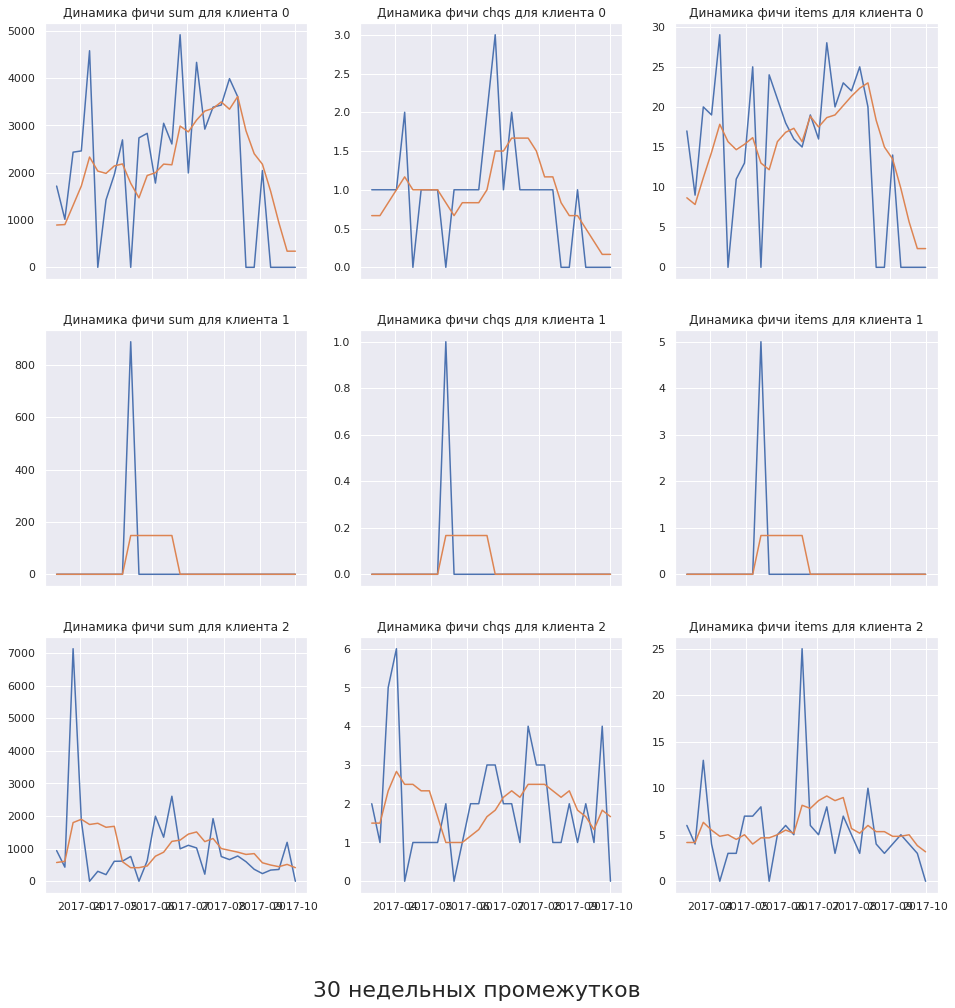

In [ ]:
feat_sets = ['sum', 'chqs', 'items']

fig, axs = plt.subplots(3, 3, figsize=(16, 16), sharex=True)
for client in range(0, 3):
    for n, feat in enumerate(feat_sets):
        lineplot_new_features(client, feat, client, n)
fig.text(0.5, 0.04, '30 недельных промежутков', ha='center', va='center', fontsize=22);

In [ ]:
cols_after_MA = cols_after_MA.reset_index()

In [ ]:
cols_after_MA = spark.createDataFrame(cols_after_MA) 

In [ ]:
df = df.join(cols_after_MA, on='client_id')

#### Разметка покупателей по оттоку
Теперь разметим клиентов на ушедших и активных на последнюю дату в наших данных.

Клиента считаем ушедшим, когда он 6 недель (42 дня) не совершает покупки.

In [ ]:
days_bw_filtered = spark.sql('''
SELECT client_id,
        ROUND(
            CAST(
                (MAX(chq_date) - MIN(chq_date)) / (COUNT(DISTINCT chq_id) - 1) AS int
                 ) / 86400, 4
              ) as d_bw
FROM trf
GROUP BY client_id
HAVING COUNT(DISTINCT chq_id) > 1
''')

In [ ]:
churned_clients = days_bw_filtered.filter('d_bw >= 42').select('client_id')
churned_clients = churned_clients.withColumn('churn', F.lit(1))
churned_clients.count()

8634

In [ ]:
df = df.join(churned_clients, on='client_id', how='left')
df = df.fillna(0)

In [ ]:
df.select(F.sum('churn')).show()

+----------+
|sum(churn)|
+----------+
|      8326|
+----------+



Количество ушедших клиентов после объединения датафреймов уменьшилось, т.к. на этапе знакомства со справочником клиентов мы отфильтровали клиентов по возрасту (18-100 лет).

In [ ]:
lifetime = spark.sql('''
    SELECT client_id, 
    (datediff(max(chq_date), min(chq_date)) + 1) as lifetime
    FROM trf
    GROUP BY client_id
    HAVING COUNT(DISTINCT chq_id) > 1
    ''')

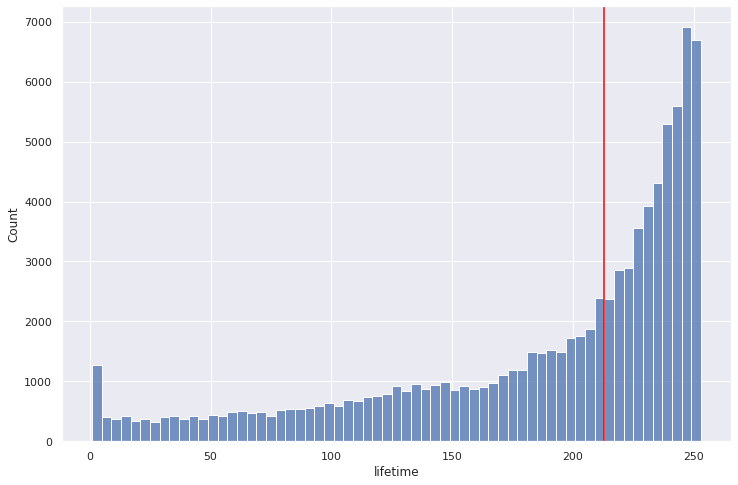

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(lifetime.toPandas()['lifetime'])
plt.axvline(lifetime.toPandas()['lifetime'].median(),
            color='red');

In [ ]:
lifetime.select(F.avg('lifetime')).show()

+------------------+
|     avg(lifetime)|
+------------------+
|186.22640930676422|
+------------------+



Медиана продолжительности пользовательской активности находится в районе 210 дней. Среднее значение смещено засчет пика количества покупателей, которые купили что либо 1-2 раза и больше не возвращались в магазин.

In [ ]:
df.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- city_client: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ratio_private_label: double (nullable = false)
 |-- ratio_alco: double (nullable = false)
 |-- promo_ratio: double (nullable = false)
 |-- chq_cnt_9m: long (nullable = false)
 |-- total_sum_9m: double (nullable = false)
 |-- cpw_9m: double (nullable = false)
 |-- ms_9m: double (nullable = false)
 |-- ipc_9m: double (nullable = false)
 |-- MA_sum_7: double (nullable = false)
 |-- MA_sum_8: double (nullable = false)
 |-- MA_sum_9: double (nullable = false)
 |-- MA_sum_10: double (nullable = false)
 |-- MA_sum_11: double (nullable = false)
 |-- MA_sum_12: double (nullable = false)
 |-- MA_sum_13: double (nullable = false)
 |-- MA_sum_14: double (nullable = false)
 |-- MA_sum_15: double (nullable = false)
 |-- MA_sum_16: double (nullable = false)
 |-- MA_sum_17: double (nullable = false)
 |-- MA_sum_18: double (nullable = fa

In [ ]:
df.agg(F.avg('churn')).show()

+-------------------+
|         avg(churn)|
+-------------------+
|0.09334290006502388|
+-------------------+



Выполним one-hot-encoding категориальных фичей. У нас таких получилось две:
1. gender
2. city_client

In [ ]:
df_pd = df.toPandas()

In [ ]:
df_pd['gender'] = pd.get_dummies(df_pd['gender'], drop_first=True)
df_pd.rename(columns={'gender': 'gender_M'}, inplace=True)

In [ ]:
city_ohe = pd.get_dummies(df_pd['city_client'])
city_ohe.rename(columns={'Moscow': 'city_msk', 'St. Petersburg': 'city_spb'}, inplace=True)
city_ohe.drop('Other', axis=1, inplace=True)

In [ ]:
df_pd = df_pd.join(city_ohe).drop('city_client', axis=1)

In [ ]:
df_pd.head()

,client_id,gender_M,age,ratio_private_label,ratio_alco,promo_ratio,chq_cnt_9m,total_sum_9m,cpw_9m,ms_9m,...,MA_items_30,MA_items_31,MA_items_32,MA_items_33,MA_items_34,MA_items_35,MA_items_36,churn,city_msk,city_spb
0,0000d48a8891cd462fdf01ea861ec53e,1,59,0.188931,0.001908,0.417143,32,68941.00,1.032258,2154.406250,...,18.333333,15.000000,13.500000,9.833333,5.666667,2.333333,2.333333,0,0,1
1,00076dd9aa78642b7254fef37a1cdb3e,0,51,0.800000,0.000000,1.000000,1,888.00,7.000000,888.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
2,0008322584b6781d656d7299e80c47f8,1,61,0.165441,0.047794,0.523810,65,32511.04,1.927966,500.169846,...,5.333333,5.333333,4.833333,4.833333,5.000000,3.833333,3.166667,0,0,0
3,000a16b7265576e37c076f1423fa45fb,0,47,0.164384,0.073059,0.344749,41,70160.00,1.253275,1711.219512,...,6.000000,7.333333,7.666667,10.000000,8.333333,6.833333,6.833333,0,0,0
4,000ac33e8990a55ba1ddd33b6300e4d3,0,32,0.158491,0.039623,0.416981,38,49222.00,1.131915,1295.315789,...,0.000000,0.000000,0.000000,2.166667,5.166667,6.166667,6.166667,0,0,1


In [ ]:
len(df_pd.columns)

104

# Обучение модели


Проверим сперва данные на мультиколлинеарность (наличие сильных корреляций переменных между собой). Для этого построим и визуализируем матрицу коэффициентов корреляций.

In [ ]:
corr_matr = df_pd.corr()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr_matr.columns,
        y = corr_matr.index,
        z = np.array(corr_matr),
        text=corr_matr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.show()

**Вывод по графику матрицы корреляций:**

Прежде всего - у нас получилась очень красивая матрица корреляции :)
Нагенерированные фичи дают красивые градиенты.

Последовательно проанализируем взаимоотношения фичей:
1. Ни одна фича не имеет даже слабой взаимосвязи с оттоком;
2. Блоки скользящих средних связаны между собой, при том чем ближе к друг другу месяцы, для которых рассчитана MA, тем сильнее корреляция:
    1. Сумма коррелирует с количеством товаров в корзине;
    2. С меньшей силой сумма коррелирует с количеством покупок;
    3. Между количеством товаров в корзине и количеством покупок корреляция менее выражена, средней силы;
3. Сильно коррелируют между собой скользящее среднее количества товаров в корзине и общая сумма покупки за весь период (9 месяцев) - неудивительно, чем больше товаров покупаешь, тем больше сумма;
4. Корреляция средней силы между скользящим средним количества товаров в корзине и количеством покупок за весь период;
5. Сильная корреляция между скользящим средним количества покупок и общей суммой покупок за период - всё логично;
6. Конечно же сильно коррелирует скользящее среднее суммы с общей суммой за период;
7. Общая сумма покупок имеет средней силы корреляцию с количеством покупок за весь период.

Заключение
* В целом все корреляции объяснимы; 
* Наши рассчитанные скользящие средние сильно коррелируют:
    * как между собой (значит можно было оставить только один набор из 3х, например, только скользящее среднее суммы);
    * так и с признаками из портрета пользователя. Посмотрим, что получится на обучении.

Сохраним отношения index - client_id в отдельную сущность, если потом понадобиться установить список клиентов, склонных к оттоку.

In [ ]:
clients_ids = df_pd['client_id']

In [ ]:
features = df_pd.drop(['client_id', 'churn'], axis=1)
target = df_pd['churn']

Для оценки модели на реалистичных данных уже на текущем этапе отделим тестовую выборку.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, stratify=target, random_state=RS)

### Подготовка выборок
Для борьбы с дисбалансом классов будем использовать технику SMOTE (Synthetic Minority Over-sampling Technique). А именно, её имплементацию в библиотеке sklern.

In [ ]:
def upsampler_SMOTE(X, y):

    print('Original dataset shape', Counter(y))
    sm = SMOTE(random_state=RS, n_jobs=-1)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape', Counter(y_res))

    return X_res, y_res

In [ ]:
X_up, y_up = upsampler_SMOTE(X_train, y_train)

Original dataset shape Counter({0: 64697, 1: 6661})
Resampled dataset shape Counter({0: 64697, 1: 64697})


### Baseline (logreg)

In [ ]:
def train_model(model, features, target):

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25, stratify=target, random_state=RS)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cr = classification_report(y_test, preds)
    return cr

In [ ]:
lr = LogisticRegression(random_state=RS)

In [ ]:
print(train_model(lr, X_up, y_up))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87     16175
           1       0.82      0.98      0.90     16174

    accuracy                           0.89     32349
   macro avg       0.90      0.89      0.89     32349
weighted avg       0.90      0.89      0.89     32349



### Обучение с Optuna

Выполним обучение и fine-tuning двух моделей:
* LogisticRegression
* LGBMClassifier

Функция `optuna_search` принимает на вход функцию, которую необходимо оптимизировать, количество испытаний в исследовании и имя исследования. Внутри:

1. Создаем экземпляр класса study из модуля Optuna, задаём направление оптимизации функции (так как у нас F1, то её максимизируем для повышения качества модели);
2. Запускам собственно процесс оптимизации созданного исследования (study) с заданным количеством испытаний (trial).

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=RS)

In [ ]:
def optuna_search(obj_func, n_trials, study_name='unnamed'):
    study = optuna.create_study(direction='maximize', study_name=study_name)
    study.optimize(obj_func, n_trials=n_trials)
    
    print(f"\tBest value (F1-score): {study.best_value:.5f}")
    print(f"\tBest params:")

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")
    return study

`objective_lr` - функция, которую будет оптимизировать Оптуна, чтобы найти наилучшие гиперпараметры. В нашей задаче бинарной классификации будем использовать метрику **f1** (среднее гармоническое точности и полноты).

In [ ]:
def objective_lr(trial: optuna.Trial):
    logreg_c = trial.suggest_float('C', 1e-10, 1e10, log=True)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    model = LogisticRegression(C=logreg_c, random_state=RS)
    scores = cross_validate(model, X_up, y_up, cv=kf, scoring="f1")
    return np.mean(scores['test_score'])

In [ ]:
%%time
lr_study = optuna_search(objective_lr, 5, 'LogReg')

[I 2022-08-18 13:56:48,454] A new study created in memory with name: LogReg
[I 2022-08-18 13:57:16,773] Trial 0 finished with value: 0.8946292362423801 and parameters: {'C': 11317280.565960612, 'tol': 0.004430800590282236}. Best is trial 0 with value: 0.8946292362423801.
[I 2022-08-18 13:57:42,312] Trial 1 finished with value: 0.8945927925062882 and parameters: {'C': 904681.0996674313, 'tol': 0.0005417545596651833}. Best is trial 0 with value: 0.8946292362423801.
[I 2022-08-18 13:58:08,606] Trial 2 finished with value: 0.8953892352769854 and parameters: {'C': 19.63984428690184, 'tol': 5.53638036542341e-05}. Best is trial 2 with value: 0.8953892352769854.
[I 2022-08-18 13:58:32,792] Trial 3 finished with value: 0.8952418923579868 and parameters: {'C': 3.3751227349456947e-06, 'tol': 0.0043633949267252205}. Best is trial 2 with value: 0.8953892352769854.
[I 2022-08-18 13:59:02,152] Trial 4 finished with value: 0.8949790361286393 and parameters: {'C': 0.22523892320754724, 'tol': 4.61905239

	Best value (F1-score): 0.89539
	Best params:
		C: 19.63984428690184
		tol: 5.53638036542341e-05
CPU times: user 3min 26s, sys: 46.7 s, total: 4min 13s
Wall time: 2min 13s


In [ ]:
def objective_lgbm(trial: optuna.Trial):
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1),
#         "max_bin": trial.suggest_int("max_bin", 30, 300)
    }
    model = LGBMClassifier(**params, random_state=RS)
    scores = cross_validate(model, X_up, y_up, cv=kf, scoring="f1", n_jobs=-1)
    return np.mean(scores['test_score'])

In [ ]:
%%time
lgbm_study = optuna_search(objective_lgbm, 5, 'LGBM')

[I 2022-08-18 14:41:57,432] A new study created in memory with name: LGBM
[I 2022-08-18 14:42:56,076] Trial 0 finished with value: 0.9997517669768463 and parameters: {'n_estimators': 100, 'learning_rate': 0.29046662180940863, 'num_leaves': 2620, 'max_depth': 4, 'min_data_in_leaf': 7210}. Best is trial 0 with value: 0.9997517669768463.
[I 2022-08-18 14:44:27,128] Trial 1 finished with value: 0.9996514805567129 and parameters: {'n_estimators': 100, 'learning_rate': 0.0902168532184382, 'num_leaves': 2780, 'max_depth': 6, 'min_data_in_leaf': 6910}. Best is trial 0 with value: 0.9997517669768463.
[I 2022-08-18 14:44:58,690] Trial 2 finished with value: 0.999712728256587 and parameters: {'n_estimators': 100, 'learning_rate': 0.2587521221479752, 'num_leaves': 440, 'max_depth': 11, 'min_data_in_leaf': 8210}. Best is trial 0 with value: 0.9997517669768463.
[I 2022-08-18 14:46:42,484] Trial 3 finished with value: 0.9997279871922211 and parameters: {'n_estimators': 100, 'learning_rate': 0.1441509

	Best value (F1-score): 0.99975
	Best params:
		n_estimators: 100
		learning_rate: 0.29046662180940863
		num_leaves: 2620
		max_depth: 4
		min_data_in_leaf: 7210
CPU times: user 3.08 s, sys: 721 ms, total: 3.8 s
Wall time: 5min 42s


# Оценка результата обучения

Функция `metric_fixer` необходима для фиксации результатов в вышеописанный датафрейм results:

1. Принимает на вход оптимизированный объект класса optuna.Study и строковое имя модели, которую мы оптимизировали;
2. Из словаря берёт "чистый" объект модели (лог.регрессию или LightGBM-классификатор);
3. Инициализирует модель с параметрами, которые были выбраны как наилучшие в процессе исследования Оптуной;
4. Обучает модель на полной обучающей выборке (при тюнинге использовалась кросс-валидация);
5. Визуализирует отчет классификации и матрицу ошибок.

In [ ]:
results = pd.DataFrame(index=['f1_train', 'f1_test'])

def metric_fixer(study: optuna.Study, model):
    
    models_dict = {
        'lr': LogisticRegression(random_state=RS),
        'lgbm': LGBMClassifier()} 
    
    model = models_dict.get(model).set_params(**study.best_params)
    model.fit(X_up, y_up)
    preds =  model.predict(X_test)
    
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)
    return None

              precision    recall  f1-score   support

           0       1.00      0.79      0.88     16175
           1       0.32      0.97      0.48      1665

    accuracy                           0.81     17840
   macro avg       0.66      0.88      0.68     17840
weighted avg       0.93      0.81      0.84     17840



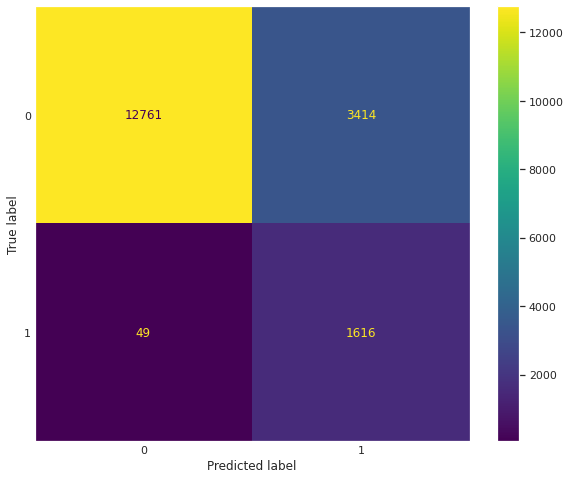

In [ ]:
metric_fixer(lr_study, 'lr')

### Логистическая регрессия

Несмотря на то, что модель дала неплохой результат при обучении (F1 = 0.89), очень плохо показала себя при тестировании - провал в точности до 0.33, хотя и полнота при этом 0.97;
* Судя по матрице ошибок модель хорошо справляется с определением истинно ушедших покупателей;
* При этом и дает много ложноположительных результатов.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16175
           1       1.00      1.00      1.00      1665

    accuracy                           1.00     17840
   macro avg       1.00      1.00      1.00     17840
weighted avg       1.00      1.00      1.00     17840



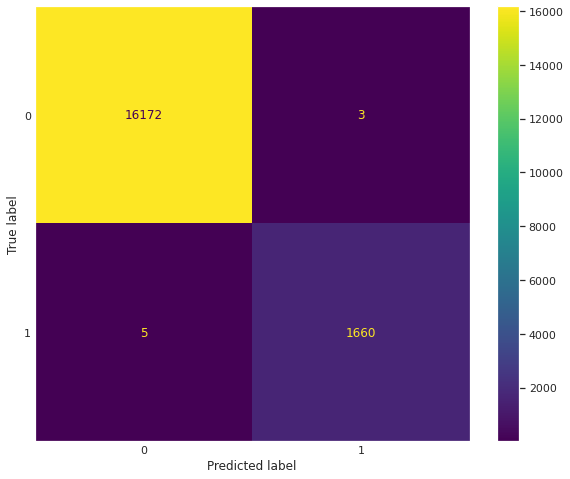

In [ ]:
metric_fixer(lgbm_study, 'lgbm')

### LightGBM

* Бустинг отлично себя показал и на обучающей, и на тестовой выборке;
* F1 на тестовой выборке близко к единице (закрадывается мысль о data leak :) );
* Во время тюнинга F1 оставалась примерно одинаковой, изменения было только в 5 цифре после запятой;
* Лучшие параметры выбранные Оптуной:
    * n_estimators: 100
	* learning_rate: 0.289
	* num_leaves: 1340
    * max_depth: 8
    * min_data_in_leaf: 1310


Посмотрим теперь, какие параметры бустинг посчитал наиболее важными.

## Оценка важности признаков

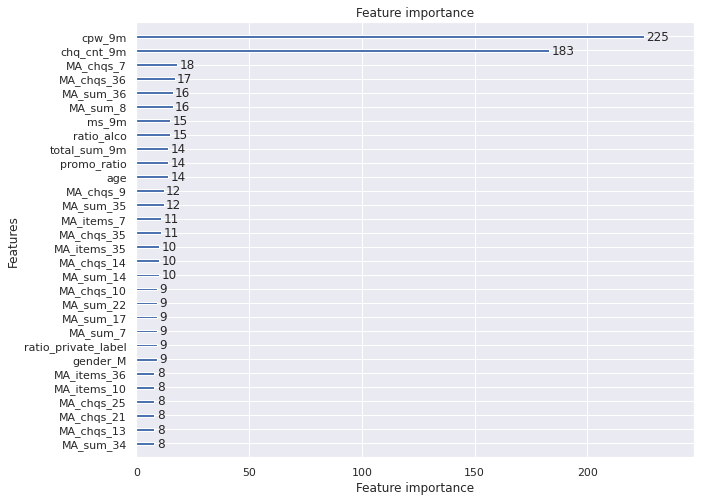

In [ ]:
booster = LGBMClassifier(**lgbm_study.best_params, random_state=RS)
booster.fit(X_up, y_up)
plot_importance(booster, max_num_features=30);

**Вывод:**

1. Наиболее важным признаком оказалось количество покупок в неделю в течение всего периода (9 мес) - потому что это прямой признак покупательской активности: чем ближе покупатель к оттоку, тем реже он совершает покупки в нашем магазине;
2. Количество покупок за весь период - второй по важности признак. Предположительно, наиболее лояльные и постоянные покупатели совершают в целом больше покупок и никуда не собираются уходить;
3. Скользящее среднее количества чеков в 7-ю неделю активности.
4. Скользящее среднее количества чеков и и суммы покупки за 36-ю неделю активности, то есть последняя неделя датасета. Логично, что на этом этапе уже понятно: какие пользователи остались, и какие ушли.
5. Средний чек за весь период, общая сумма трат - вносят уже меньший вклад в предсказания, но тем не менее являются частью портрета пользователя;
6. Третий признак - `promo_ratio` - это соотношение промо-товаров и всех товаров. Очевидно, что более лояльные покупатели являются более склонными к участию в промо-акциях, с радостью берут товары с "желтыми" ценниками;
7. Возраст покупателя - основная часть нашей покупательской аудитории это люди от 25 до 55 лет. Этот факт тоже можно использовать при разделении наблюдений.
